# Run everything and compare to SSPs

In [1]:
from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import pooch

In [2]:
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
runs = [1, 2, 3, 4, 8]

In [3]:
temp_ukesm = np.ones((251, 4, 5)) * np.nan
for iscen, scenario in enumerate(scenarios):
    for irun, run in enumerate(runs):
        temp_ukesm[:165, iscen, irun] = pd.read_csv(f'../data/fredriksen2022/historical/UKESM1-0-LL_historical_r{run}i1p1f2_anomalies.txt', index_col=0)['tas'].values
        temp_ukesm[165:, iscen, irun] = pd.read_csv(f'../data/fredriksen2022/{scenario}/UKESM1-0-LL_{scenario}_r{run}i1p1f2_anomalies.txt', index_col=0)['tas'].values

In [4]:
climate_response_df = pd.read_csv('../data/fair-calibrations/4xCO2_energy_balance_ebm3.csv')

In [5]:
natural_forcing_df = pd.read_csv('../data/calibration/natural_forcing.csv', index_col=0)

In [6]:
f = FAIR()

In [7]:
configs = ['UKESM1-0-LL']
species, properties = read_properties()
species.remove('CO2 FFI')      # c-driven run
#species.remove('CO2 AFOLU')    # c-driven run
species.remove('Halon-1202')   # not in CMIP6 list of species
species.remove('Contrails')    # not modelled in UKESM, I think
species.remove('NOx aviation') # which renders this redundant
species.remove('Light absorbing particles on snow and ice')  # I believe not modelled in UKESM
del properties['CO2 FFI']
#del properties['CO2 AFOLU']
del properties['Halon-1202']
del properties['Contrails']
del properties['NOx aviation']
del properties['Light absorbing particles on snow and ice']
for specie in species:
    if properties[specie]['greenhouse_gas']:
        properties[specie]['input_mode'] = 'concentration'
#properties['Land use']['input_mode'] = 'forcing'
#properties

In [8]:
f.define_time(1850, 2101, 1)
f.define_scenarios(scenarios)
f.define_configs(configs)
f.define_species(species, properties)

In [9]:
f.allocate()

In [10]:
fill(f.climate_configs['ocean_heat_capacity'], climate_response_df.loc[0, 'C1':'C3'])
fill(f.climate_configs['ocean_heat_transfer'], climate_response_df.loc[0, 'kappa1':'kappa3'])
fill(f.climate_configs['deep_ocean_efficacy'], climate_response_df.loc[0, 'epsilon'])
fill(f.climate_configs['gamma_autocorrelation'], climate_response_df.loc[0, 'gamma'])

In [11]:
initialise(f.forcing, 0)
initialise(f.temperature, 0)

In [12]:
f.fill_species_configs()

In [13]:
f.fill_from_rcmip()

In [14]:
#landuse_erf = pd.read_csv('../data/calibration/landuse_forcing.csv', index_col=0)
#f.forcing.loc[dict(specie='Land use')] = landuse_erf.values[:, None]

In [15]:
# 1850 baselines
for specie in ['Sulfur', 'BC', 'OC', 'NOx', 'VOC', 'CO', 'NH3']:
    f.species_configs['baseline_emissions'].loc[dict(specie=specie)] = f.emissions.loc[dict(specie=specie, timepoints=1850.5, scenario='ssp245')]

for specie in ['CO2', 'CH4', 'N2O', 'CFC-11', 'CFC-12', 'CFC-113', 'CFC-114', 'CFC-115', 'HCFC-22', 'HCFC-141b', 'HCFC-142b',
    'CCl4', 'CHCl3', 'CH2Cl2', 'CH3Cl', 'CH3CCl3', 'CH3Br', 'Halon-1211', 'Halon-1301', 'Halon-2402',
    'CF4', 'C2F6', 'C3F8', 'c-C4F8', 'C4F10', 'C5F12', 'C6F14', 'C7F16', 'C8F18', 'NF3', 'SF6', 'SO2F2',
    'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa',
    'HFC-32', 'HFC-365mfc', 'HFC-4310mee']:
    f.species_configs['baseline_concentration'].loc[dict(specie=specie)] = f.concentration.loc[dict(specie=specie, timebounds=1850, scenario='ssp245')]

f.species_configs['baseline_concentration'].loc[dict(specie='Equivalent effective stratospheric chlorine')] = 0

## rebase volcanic to zero mean
#f.forcing.loc[dict(specie='Volcanic')] = f.forcing.loc[dict(specie='Volcanic')] - f.forcing.loc[dict(specie='Volcanic', scenario='ssp245', config='UKESM1-0-LL')].mean()

# override RCMIP natural forcing
fill(f.forcing, natural_forcing_df.loc[1850:2101, 'solar'][:, None, None], specie='Solar')
fill(f.forcing, natural_forcing_df.loc[1850:2101, 'volcanic'][:, None, None], specie='Volcanic')

/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_90304/1522229335.py:18: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  fill(f.forcing, natural_forcing_df.loc[1850:2101, 'solar'][:, None, None], specie='Solar')
/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_90304/1522229335.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  fill(f.forcing, natural_forcing_df.loc[1850:2101, 'volcanic'][:, None, None], specie='Volcanic')


In [16]:
ods = ['CFC-11', 'CFC-12', 'CFC-113', 'CFC-114', 'CFC-115', 'HCFC-22', 'HCFC-141b', 'HCFC-142b',
        'CCl4', 'CHCl3', 'CH2Cl2', 'CH3Cl', 'CH3CCl3', 'CH3Br', 'Halon-1211', 'Halon-1301', 'Halon-2402']

hfc = ['CF4', 'C2F6', 'C3F8', 'c-C4F8', 'C4F10', 'C5F12', 'C6F14', 'C7F16', 'C8F18', 'NF3', 'SF6', 'SO2F2',
        'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa', 'HFC-32',
        'HFC-365mfc', 'HFC-4310mee']

In [17]:
# UKESM specific ESM component calibrations: DO NOT MODIFY
f.species_configs['land_use_cumulative_emissions_to_forcing'].loc[dict(specie="CO2 AFOLU")] = 0.0003024895261521421
f.species_configs['forcing_scale'].loc[dict(specie="CH4")] = 1.11547955
f.species_configs['h2o_stratospheric_factor'].loc[dict(specie="CH4")] = 1.29652705e-01
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="CH4")] = 1.27049657e-04
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="Equivalent effective stratospheric chlorine")] = -0.00029119797470220245
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="N2O")] = 0.0007481397748679878
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="VOC")] = 0.0006596999582126578
f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="NOx")] = 0.000984642055228785
f.species_configs['forcing_temperature_feedback'].loc[dict(specie="Ozone")] = -0.079  # Recalibrated feedback from 11b
f.species_configs['forcing_scale'].loc[dict(specie="N2O")] = 1.0845323023219764
f.species_configs['forcing_scale'].loc[dict(specie="CO2")] = 0.9935419214400296

for specie in species:
    f.species_configs['erfari_radiative_efficiency'].loc[dict(specie=specie)] = 0
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='Sulfur')] = -0.00447635
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='BC')] = 0.05297455
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='OC')] = -0.00781294
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='CH4')] = -5.09377882e-05
f.species_configs['aci_scale'].loc[dict(config='UKESM1-0-LL')] = -0.63667782
f.species_configs['aci_shape'].loc[dict(specie='Sulfur')] = 0.03110931
f.species_configs['aci_shape'].loc[dict(specie='BC')] = 0.00221948
f.species_configs['aci_shape'].loc[dict(specie='OC')] = 0.00864984
f.species_configs['aci_shape'].loc[dict(specie='CH4')] = -3.54174562e-04

for specie in ods:
    f.species_configs['forcing_scale'].loc[dict(specie=specie)] = 1.33139609
for specie in hfc:
    f.species_configs['forcing_scale'].loc[dict(specie=specie)] = 0.25250486
    
# this bit you can modify to try and get a better result
f.species_configs['aci_shape'].loc[dict(specie='Sulfur')] = 0.03110931 * 2
#f.species_configs['forcing_temperature_feedback'].loc[dict(specie="Aerosol-radiation interactions")] = -0.1
f.species_configs['forcing_temperature_feedback'].loc[dict(specie="Aerosol-cloud interactions")] = 0
f.species_configs['forcing_efficacy'].loc[dict(specie="Aerosol-cloud interactions")] = 1.1

In [18]:
f.run()

Running 4 projections in parallel:   0%|          | 0/251 [00:00<?, ?timesteps/s]

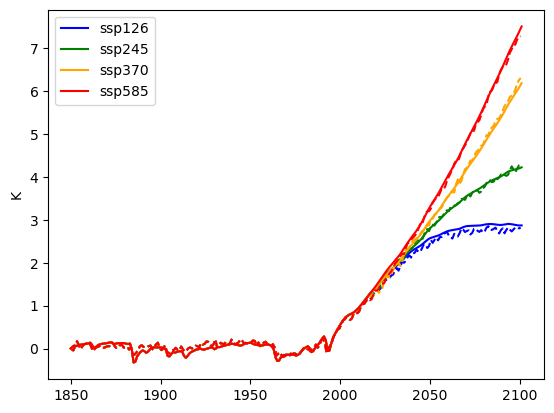

In [19]:
colors = ['blue', 'green', 'orange', 'red']
for iscen, scenario in enumerate(scenarios):
    pl.plot(f.timebounds, f.temperature[:, iscen, 0, 0], color=colors[iscen], label=scenario)
    pl.plot(np.arange(1850.5, 2101), temp_ukesm[:, iscen, :].mean(axis=1), color=colors[iscen], ls='--')
pl.legend()
pl.ylabel('K')
pl.savefig('../plots/calibrated_coupled.png')

In [20]:
f.forcing_sum

<xarray.DataArray (timebounds: 252, scenario: 4, config: 1)>
array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.24759648],
        [0.24759648],
        [0.24759648],
        [0.24759648]],

       [[0.23400637],
        [0.23400637],
        [0.23400637],
        [0.23400637]],

       ...,

       [[2.84316285],
        [4.55159046],
        [7.23216956],
        [8.80499738]],

       [[2.84602189],
        [4.56622894],
        [7.31641918],
        [8.90169522]],

       [[2.86524981],
        [4.59647957],
        [7.41679219],
        [9.01424845]]])
Coordinates:
  * timebounds  (timebounds) float64 1.85e+03 1.851e+03 ... 2.1e+03 2.101e+03
  * scenario    (scenario) <U6 'ssp126' 'ssp245' 'ssp370' 'ssp585'
  * config      (config) <U11 'UKESM1-0-LL'